### Analysis Version 3 (a version that actually works)
##### *Highlights from model, state-by-state analysis, and aggregate review.*

Following the results of the updated optimisation model, this notebook aims to shed light on the outcomes. In general, it seeks to answer the question '*how can biofuels complement electrification?*' at a county level, across the set of chosen states (MN, TX, CA).

Between model v0.1 and model v0.2, the following changes were made:
- Solutions involve running linear regression in order to better understand county-level factors allowing
- Adding at-home charging to EV viability index

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

In [2]:
selected_states = ['CA','TX','MN']
vdf = pd.read_csv('optimisation_data/visual_df.csv')
del vdf['Unnamed: 0']

In [3]:
vdf['annual_ghg_emissions'].mean()

520760468398.2461

In [4]:
ca_vdf = vdf[vdf['State']=='CA']
tx_vdf = vdf[vdf['State']=='TX']
mn_vdf = vdf[vdf['State']=='MN']
a = pd.Series(vdf.mean(), name='overall_mean')
b = pd.Series(ca_vdf.mean(), name='mn_mean')
c = pd.Series(tx_vdf.mean(), name='tx_mean')
d = pd.Series(mn_vdf.mean(), name='ca_mean')
pd.DataFrame([a,b,c,d]).T

,overall_mean,mn_mean,tx_mean,ca_mean
annual_ghg_emissions,520760468398.25,1504381095330.31,348879536151.38,366826680221.75
annual_operating_cost,43985842.79,168284900.52,19948291.42,31298402.56
total_annual_cost,948112519.17,3100346634.16,594335818.82,546155084.90
annual_fuel_use,22546952.26,71845909.70,13680793.30,15566088.39
total_vehicle_count,154795.45,507595.84,98121.35,85057.48
vehicle_split_BEV,121483.41,434534.34,70894.22,60479.99
vehicle_split_FFV,10648.13,33241.04,5538.78,10503.15
vehicle_split_SIDI,22663.90,39820.47,21688.35,14074.34
vehicle_pc_BEV,33.52,65.47,27.78,28.97
vehicle_pc_FFV,6.57,1.98,2.23,22.31


In [5]:
evi = pd.read_csv('efuels_vi.csv')
del evi['Unnamed: 0']
evi.columns
evi.efuels_area = evi.efuels_area*100

In [6]:
# evi[evi['NAME']=="Anoka"]
evi.head(5)

,state,county,census_area,efuels_area
0,CA,Lassen,4541.18,3.21
1,CA,Modoc,3917.77,5.29
2,CA,San Francisco,46.87,100.00
3,CA,Santa Barbara,2735.09,73.62
4,CA,Sierra,953.21,15.63


In [7]:
# evi.NAME = evi.NAME.str.replace('_',' ')
# evi = evi[['NAME','efuels_area','CENSUSAREA']]
vdf = vdf.merge(evi, left_on='County',right_on='county')
vdf.rename(columns={'CENSUSAREA':'census_area'}, inplace=True)
vdf.drop('county', axis=1,inplace=True)
vdf.drop('state', axis=1,inplace=True)

In [8]:
ru = pd.read_csv('preprocessed_data/rural_urban.csv')
del ru['Note']
ru = ru[ru.State.isin(selected_states)]
ru.rename(columns = {'2015 Geography Name':'County','2010 Census \nPercent Rural' : 'pct_rural',
                    '2010 Census Total Population':'census_totpop', '2010 Census Rural Population':'census_rurpop',
                    '2010 Census Urban Population':'census_urbpop'},inplace=True)

ru.County = ru.County.str.replace(' County, Texas','')
ru.County = ru.County.str.replace(' County, California','')
ru.County = ru.County.str.replace(' County, Minnesota','')

In [9]:
#cleaning up the document here to ensure that we have the right names
repeated_list = ['Orange','Cass','Lake','Trinity','Houston','Polk','Brown','Clay','Jackson','Washington','Martin']
ru.loc[ru['County'].isin(repeated_list), 'County'] = ru['County'] + ' ' + ru['State']
vdf = vdf.merge(ru)
#checking if the sets are the same
misfits = set(ru.County).symmetric_difference(set(vdf.County))
len(misfits)

0

In [10]:
vdf['census_totpop'] = vdf['census_totpop'].apply(lambda x: x.replace(',','')).astype(int)
vdf['census_urbpop'] = vdf['census_urbpop'].apply(lambda x: x.replace(',','')).astype(int)
vdf['census_rurpop'] = vdf['census_rurpop'].apply(lambda x: x.replace(',','')).astype(int)
vdf['pop_density'] =vdf['census_totpop']/vdf['census_area']
trunc = lambda x: math.trunc(1000 * x) / 1000
vdf['census_area'] = vdf['census_area'].apply(trunc)

vdf.loc[vdf['pop_density'] >= 750, 'county_class'] = 'urban'
vdf.loc[vdf['pop_density'] <= 750, 'county_class'] = 'suburban'
vdf.loc[vdf['pct_rural'] >= 50, 'county_class'] = 'rural'

In [11]:
# vdf.loc[vdf['county_class'] == 'suburban','efuels_area'] = vdf['efuels_area']+40
# vdf.loc[vdf['county_class'] == 'urban','efuels_area'] = vdf['efuels_area']+25

# vdf['efuels_area'] = vdf['efuels_area'].apply(lambda x: 100 if x >= 100 else x)

In [12]:
vdf['efuels_area'].describe()

count   399.00
mean     33.51
std      32.37
min       0.00
25%       0.00
50%      36.77
75%      55.62
max     100.00
Name: efuels_area, dtype: float64

In [13]:
vdf[vdf['County']=='Jeff Davis'][['County','State','efuels_area']]

,County,State,efuels_area
266,Jeff Davis,TX,4.89


In [14]:
vdf['vehicle_pc_SIDI'].mean()

59.90927318295743

In [15]:
vdf['census_rurpop'].corr(vdf['efuels_area'])

0.41042060639905903

In [16]:
vdf['efuels_area'].corr(vdf['census_rurpop'])

0.410420606399059

In [17]:
vdf.sort_values(by='pop_density',ascending=False).head()[['County','census_area','efuels_area','census_totpop','census_urbpop','census_rurpop','pct_rural','pop_density']]

,County,census_area,efuels_area,census_totpop,census_urbpop,census_rurpop,pct_rural,pop_density
37,San Francisco,46.87,100.00,805235,805235,0,0.00,17179.08
29,Orange CA,790.57,100.00,3010232,3005917,4315,0.10,3807.68
119,Ramsey,152.21,100.00,508640,507688,952,0.20,3341.66
201,Dallas,871.28,100.00,2368139,2351839,16300,0.70,2718.00
18,Los Angeles,4057.88,87.97,9818605,9759181,59424,0.60,2419.64


In [18]:
from sklearn.linear_model import LinearRegression
X = vdf['efuels_area'].values.reshape(-1, 1)  # values converts it into a numpy array
y = vdf['pop_density'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
X.mean()

33.51434334951582

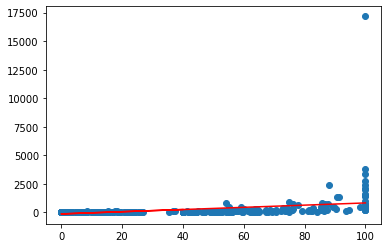

In [19]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, y)  # perform linear regression
y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

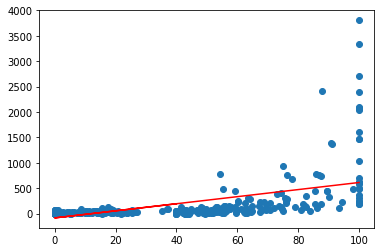

In [20]:
X_new = vdf[vdf.County != 'San Francisco']['efuels_area'].values.reshape(-1,1)
y_new = vdf[vdf.County != 'San Francisco']['pop_density'].values.reshape(-1,1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_new, y_new)  # perform linear regression
y_newpred = linear_regressor.predict(X_new)  # make predictions
plt.scatter(X_new, y_new)
plt.plot(X_new, y_newpred, color='red')
plt.show()

##### Overall results:

In [21]:
vdf[['State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area']].groupby(by='State').mean()

,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area
State,,,,
CA,65.47,1.98,32.56,65.46
MN,28.97,22.31,48.71,28.97
TX,27.78,2.23,69.99,27.78


In [22]:
# vdf[vdf['State']=='CA'].sort_values(by='efuels_area',ascending=True).head()
# vdf[(vdf['State']=='TX') & (vdf['vehicle_pc_FFV']>vdf['vehicle_pc_BEV'])].sort_values(by='vehicle_pc_FFV',ascending=False)
vdf[(vdf['State']=='MN') & (vdf['vehicle_pc_FFV']>0)].sort_values(by='vehicle_pc_FFV',ascending=False).head(10)

,County,annual_ghg_emissions,annual_operating_cost,total_annual_cost,annual_fuel_use,total_vehicle_count,vehicle_split_BEV,vehicle_split_FFV,vehicle_split_SIDI,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,State,census_area,efuels_area,census_totpop,census_urbpop,census_rurpop,pct_rural,pop_density,county_class
138,Waseca,118811080000.00,12959585.50,187710128.00,8960031.00,26698.00,0.00,18181.09,8516.91,0.00,68.10,31.90,MN,423.36,0.00,19136,9537,9599,50.20,45.20,rural
74,Cottonwood,60027191000.00,7994397.30,114724579.00,5434810.40,16306.00,0.00,10135.02,6170.98,0.00,62.20,37.80,MN,638.61,0.00,11687,4409,7278,62.30,18.30,rural
144,Yellow Medicine,53904179100.00,7100187.86,102226657.20,4792604.15,14563.00,281.56,8778.78,5502.66,1.90,60.30,37.80,MN,759.10,1.93,10438,2002,8436,80.80,13.75,rural
70,Chisago,262738283000.00,29027294.60,499582700.00,18584589.00,75183.00,31120.72,44062.29,0.00,41.40,58.60,0.00,MN,414.86,41.39,53887,23932,29955,55.60,129.89,rural
97,Le Sueur,142842975000.00,17362337.30,264758822.00,11338910.00,38651.00,8074.76,21699.13,8877.11,20.90,56.10,23.00,MN,448.76,20.89,27703,10483,17220,62.20,61.73,rural
89,Jackson MN,51676333000.00,7094753.80,100845299.00,4739442.50,14323.00,0.00,8014.81,6308.19,0.00,56.00,44.00,MN,702.98,0.00,10266,3169,7097,69.10,14.60,rural
122,Renville,83133503000.00,10104880.40,151224580.00,6587460.35,21946.00,3648.81,11824.83,6472.37,16.60,53.90,29.50,MN,982.91,16.63,15730,0,15730,100.00,16.00,rural
121,Redwood,87452795000.00,10409496.80,154731846.00,6784123.84,22405.00,3362.48,11907.55,7134.97,15.00,53.10,31.80,MN,878.57,15.01,16059,4958,11101,69.10,18.28,rural
130,Stearns,964809632000.00,82870143.10,1387915050.00,50608526.50,210174.99,102013.92,102743.90,5417.17,48.50,48.90,2.60,MN,1343.13,48.54,150642,95005,55637,36.90,112.16,suburban
87,Isanti,235166544000.00,22102602.20,353794725.00,13764377.40,52761.00,19714.56,25766.96,7279.48,37.40,48.80,13.80,MN,435.79,37.37,37816,14270,23546,62.30,86.77,rural


In [23]:
# vdf[(vdf['State']=='TX')].sort_values(by='annual_ghg_emissions',ascending=False).head(30)
# vdf[(vdf['State']=='CA')].sort_values(by='total_vehicle_count',ascending=False)

In [24]:
vdf[(vdf['State']=='TX') & (vdf['vehicle_pc_BEV']==0) & (vdf['vehicle_pc_FFV']>0)].sort_values(by='vehicle_pc_FFV',ascending=False)
# vdf[(vdf['State']=='CA') & (vdf['vehicle_pc_BEV']>0)].sort_values(by='vehicle_pc_FFV',ascending=False).mean()
# vdf[(vdf['State']=='TX') & (vdf['County']=='Harris')].sort_values(by='vehicle_pc_FFV',ascending=False)

,County,annual_ghg_emissions,annual_operating_cost,total_annual_cost,annual_fuel_use,total_vehicle_count,vehicle_split_BEV,vehicle_split_FFV,vehicle_split_SIDI,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,State,census_area,efuels_area,census_totpop,census_urbpop,census_rurpop,pct_rural,pop_density,county_class
151,Atascosa,291744672500.00,23595841.00,355319474.00,18171949.20,50680.00,0.00,4936.30,45743.70,0.00,9.70,90.30,TX,1219.54,0.00,44911,17645,27266,60.70,36.83,rural
331,Polk TX,330729548400.00,26663853.40,398877667.00,20509589.40,56866.00,0.00,4801.87,52064.13,0.00,8.40,91.60,TX,1057.09,0.00,45413,10155,35258,77.60,42.96,rural
307,Medina,143992358200.00,27755904.87,399910818.20,21203955.66,56857.00,0.00,501.54,56355.46,0.00,0.90,99.10,TX,1325.36,0.00,46006,17687,28319,61.60,34.71,rural


In [25]:
interested_counties_ca = ['San Francisco','Los Angeles','San Bernardino'] 
interested_counties_mn = ['Ramsey','Hennepin','St. Louis']
interested_counties_tx = ['Bexar','Dallas','Comal','Lubbock','Travis']

In [26]:
#global ranking (across the sample)
vdf['ghg_globalrank'] = vdf['annual_ghg_emissions'].rank(ascending=False)
vdf['popden_globalrank'] = vdf['pop_density'].rank(ascending=False)
vdf['censusarea_globalrank'] = vdf['census_area'].rank(ascending=False)

#state ranking (within state)
vdf['ghg_staterank'] = vdf.groupby('State')['annual_ghg_emissions'].rank('dense', ascending=False)
vdf['popden_staterank'] = vdf.groupby('State')['pop_density'].rank('dense', ascending=False)
vdf['censusarea_staterank'] = vdf.groupby('State')['census_area'].rank('dense', ascending=False)

In [27]:
vdf.to_feather('analysed_vdf')

In [28]:
# vdf[vdf['County']].isin(['San Francisco','Los Angeles','San Bernadino'])
vdf[vdf['County'].isin(interested_counties_ca)][['County','State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','ghg_globalrank','ghg_staterank','popden_globalrank','popden_staterank','censusarea_globalrank','censusarea_staterank']]

,County,State,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,ghg_globalrank,ghg_staterank,popden_globalrank,popden_staterank,censusarea_globalrank,censusarea_staterank
18,Los Angeles,CA,88.00,12.00,0.00,1.00,1.00,5.00,3.00,15.00,11.00
35,San Bernardino,CA,49.90,4.30,45.90,11.00,6.00,88.00,32.00,1.00,1.00
37,San Francisco,CA,100.00,0.00,0.00,33.00,16.00,1.00,1.00,399.00,58.00


In [29]:
vdf[vdf['County'].isin(interested_counties_mn)][['County','State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','ghg_globalrank','ghg_staterank','popden_globalrank','popden_staterank','censusarea_globalrank','censusarea_staterank']]

,County,State,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,ghg_globalrank,ghg_staterank,popden_globalrank,popden_staterank,censusarea_globalrank,censusarea_staterank
84,Hennepin,MN,100.00,0.00,0.00,6.00,1.00,8.00,2.00,348.00,60.00
119,Ramsey,MN,100.00,0.00,0.00,14.00,2.00,3.00,1.00,397.00,87.00
126,St. Louis,MN,50.80,3.60,45.60,36.00,6.00,184.00,38.00,6.00,1.00


In [30]:
vdf[vdf['County'].isin(interested_counties_tx)][['County','State','ghg_globalrank','ghg_staterank','popden_globalrank','popden_staterank','censusarea_globalrank','censusarea_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']]

,County,State,ghg_globalrank,ghg_staterank,popden_globalrank,popden_staterank,censusarea_globalrank,censusarea_staterank,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI
159,Bexar,TX,10.00,4.00,13.00,4.00,91.00,37.00,90.70,9.30,0.00
190,Comal,TX,93.00,45.00,57.00,29.00,346.00,234.00,81.60,18.40,0.00
201,Dallas,TX,2.00,1.00,4.00,1.00,248.00,177.00,100.00,0.00,0.00
296,Lubbock,TX,54.00,21.00,40.00,19.00,224.00,155.00,63.70,29.40,6.90
371,Travis,TX,31.00,11.00,15.00,5.00,139.00,76.00,100.00,0.00,0.00


In [31]:
vdf[['County','State','ghg_globalrank','ghg_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']].sort_values(by=['ghg_staterank','ghg_globalrank'],ascending=True).head(10)

,County,State,ghg_globalrank,ghg_staterank,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI
18,Los Angeles,CA,1.00,1.00,88.00,12.00,0.00
201,Dallas,TX,2.00,1.00,100.00,0.00,0.00
84,Hennepin,MN,6.00,1.00,100.00,0.00,0.00
29,Orange CA,CA,3.00,2.00,100.00,0.00,0.00
364,Tarrant,TX,4.00,2.00,100.00,0.00,0.00
119,Ramsey,MN,14.00,2.00,100.00,0.00,0.00
32,Riverside,CA,5.00,3.00,75.80,16.80,7.40
245,Harris,TX,7.00,3.00,100.00,0.00,0.00
76,Dakota,MN,19.00,3.00,100.00,0.00,0.00
42,Santa Clara,CA,8.00,4.00,91.20,8.80,0.00


In [32]:
vdf[['County','State','popden_globalrank','popden_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']].sort_values(by=['popden_staterank','popden_globalrank'],ascending=True).head(10)

,County,State,popden_globalrank,popden_staterank,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI
37,San Francisco,CA,1.00,1.00,100.00,0.00,0.00
119,Ramsey,MN,3.00,1.00,100.00,0.00,0.00
201,Dallas,TX,4.00,1.00,100.00,0.00,0.00
29,Orange CA,CA,2.00,2.00,100.00,0.00,0.00
245,Harris,TX,6.00,2.00,100.00,0.00,0.00
84,Hennepin,MN,8.00,2.00,100.00,0.00,0.00
18,Los Angeles,CA,5.00,3.00,88.00,12.00,0.00
364,Tarrant,TX,7.00,3.00,100.00,0.00,0.00
59,Anoka,MN,18.00,3.00,85.70,14.30,0.00
0,Alameda,CA,9.00,4.00,100.00,0.00,0.00


In [33]:
vdf[['County','State','censusarea_globalrank','censusarea_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']].sort_values(by=['censusarea_staterank','censusarea_globalrank'],ascending=True).head(10)

,County,State,censusarea_globalrank,censusarea_staterank,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI
35,San Bernardino,CA,1.00,1.00,49.90,4.30,45.90
126,St. Louis,MN,6.00,1.00,50.80,3.60,45.60
166,Brewster,TX,7.00,1.00,40.00,0.00,60.00
13,Inyo,CA,2.00,2.00,43.40,0.00,56.60
330,Pecos,TX,10.00,2.00,42.70,0.00,57.30
93,Koochiching,MN,27.00,2.00,40.00,0.00,60.00
14,Kern,CA,3.00,3.00,62.80,2.00,35.30
259,Hudspeth,TX,11.00,3.00,0.50,0.00,99.50
88,Itasca,MN,32.00,3.00,0.00,4.10,95.90
32,Riverside,CA,4.00,4.00,75.80,16.80,7.40


In [34]:
#introducing VMT
VMT = pd.read_csv('./vmt/vmt_transpose.csv')
VMT['Classification'] = VMT['Classification'].str.lower()
N = pd.read_csv('https://raw.githubusercontent.com/saif1457/biofuels/master/optimisation_data/N(r).csv')
N.county = N.county.str.replace('_',' ')

In [35]:
vdf = vdf.merge(N, left_on='County',right_on='county')
vdf.shape

(399, 30)

In [36]:
vdf = vdf.merge(VMT,left_on=['household_income_ID','State','county_class'],right_on=['household_income_ID','state','Classification'])
vdf.shape

(399, 34)

In [37]:
del vdf['county']
del vdf['state']
vdf.columns

Index(['County', 'annual_ghg_emissions', 'annual_operating_cost',
       'total_annual_cost', 'annual_fuel_use', 'total_vehicle_count',
       'vehicle_split_BEV', 'vehicle_split_FFV', 'vehicle_split_SIDI',
       'vehicle_pc_BEV', 'vehicle_pc_FFV', 'vehicle_pc_SIDI', 'State',
       'census_area', 'efuels_area', 'census_totpop', 'census_urbpop',
       'census_rurpop', 'pct_rural', 'pop_density', 'county_class',
       'ghg_globalrank', 'popden_globalrank', 'censusarea_globalrank',
       'ghg_staterank', 'popden_staterank', 'censusarea_staterank',
       'median_household_income_2018', 'household_income_ID', 'Income Class',
       'Classification', 'VMT'],
      dtype='object')

In [38]:
#cleaning up the table
vdf = vdf.rename(columns={'VMT':'annual_vmt'})
vdf = vdf[['County','State','annual_ghg_emissions',
 'annual_operating_cost',
 'total_annual_cost',
 'annual_fuel_use',
 'total_vehicle_count',
 'vehicle_split_BEV',
 'vehicle_split_FFV',
 'vehicle_split_SIDI',
 'vehicle_pc_BEV',
 'vehicle_pc_FFV',
 'vehicle_pc_SIDI',
 'efuels_area',
 'census_area',
 'census_totpop',
 'census_urbpop',
 'census_rurpop',
 'pct_rural',
 'pop_density',
 'county_class',
 'ghg_globalrank',
 'popden_globalrank',
 'censusarea_globalrank',
 'ghg_staterank',
 'popden_staterank',
 'censusarea_staterank',
 'median_household_income_2018',
 'household_income_ID',
 'annual_vmt']]
vdf.columns

Index(['County', 'State', 'annual_ghg_emissions', 'annual_operating_cost',
       'total_annual_cost', 'annual_fuel_use', 'total_vehicle_count',
       'vehicle_split_BEV', 'vehicle_split_FFV', 'vehicle_split_SIDI',
       'vehicle_pc_BEV', 'vehicle_pc_FFV', 'vehicle_pc_SIDI', 'efuels_area',
       'census_area', 'census_totpop', 'census_urbpop', 'census_rurpop',
       'pct_rural', 'pop_density', 'county_class', 'ghg_globalrank',
       'popden_globalrank', 'censusarea_globalrank', 'ghg_staterank',
       'popden_staterank', 'censusarea_staterank',
       'median_household_income_2018', 'household_income_ID', 'annual_vmt'],
      dtype='object')

In [39]:
vdf.to_csv('vdf_v4.csv')

In [40]:
model = pd.read_csv('vdf_v4.csv')
del model['Unnamed: 0']

In [41]:
model.shape

(399, 30)

In [42]:
efuel_station_count = pd.read_csv('efuel_station_count')
del efuel_station_count['Unnamed: 0']

In [43]:
model = model.merge(efuel_station_count,how='left')
model.shape

(399, 31)

In [71]:
import feather
e85_store = pd.read_feather('./e85_store', use_threads=True)
e85_store = e85_store[['NAME','e85_area','Station Count']]
e85_store = e85_store.rename(columns={'NAME':'County','Station Count':'E85 Station Count'})
e85_store.County = e85_store.County.str.replace('_',' ')

In [72]:
e85_vi = pd.read_csv('./e85_vi.csv')
e85_vi.county = e85_vi.county.str.replace('_',' ')
e85_vi.shape

(399, 5)

In [73]:
e85_store = e85_store.merge(e85_vi, left_on='County',right_on='county')
e85_store.shape

In [75]:
del e85_vi['Unnamed: 0']
e85_store = e85_store[['County','e85_area_y','E85 Station Count']]
e85_store = e85_store.rename(columns={'e85_area_y':'e85_area'})
e85_store.e85_area = e85_store.e85_area*100

In [77]:
e85_store.shape

(399, 3)

In [78]:
model = model.merge(e85_store)

In [80]:
model[['State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','annual_vmt']].groupby(by='State').mean()

,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area,e85_area,annual_vmt
State,,,,,,
CA,65.47,1.98,32.56,65.46,9.97,10690.08
MN,28.97,22.31,48.71,28.97,34.34,13610.84
TX,27.78,2.23,69.99,27.78,5.36,12040.47


In [81]:
model.shape

(399, 33)

In [82]:
model[model['State']=='CA']['vehicle_pc_BEV'].mean()

65.46896551724137

In [83]:
model[model['State']=='TX']['vehicle_pc_FFV'].mean()

2.230708661417323

In [84]:
model[model['State']=='MN']['vehicle_pc_SIDI'].mean()

48.71034482758621

In [85]:
model[model['County']=='Traverse']

,County,State,annual_ghg_emissions,annual_operating_cost,total_annual_cost,annual_fuel_use,total_vehicle_count,vehicle_split_BEV,vehicle_split_FFV,vehicle_split_SIDI,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area,census_area,census_totpop,census_urbpop,census_rurpop,pct_rural,pop_density,county_class,ghg_globalrank,popden_globalrank,censusarea_globalrank,ghg_staterank,popden_staterank,censusarea_staterank,median_household_income_2018,household_income_ID,annual_vmt,Efuel Station Count,e85_area,E85 Station Count
64,Traverse,MN,23465278000.00,2472513.00,34964149.00,1412864.50,4964.00,0.00,0.00,4964.00,0.00,0.00,100.00,0.00,573.90,3558,0,3558,100.00,6.20,rural,339.00,326.00,341.00,85.00,81.00,55.00,"$49,773",5,10517.98,nan,28.72,2.00


In [86]:
model.efuels_area.mean()

33.514343349515805

In [87]:
model[['vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','county_class', 'E85 Station Count','Efuel Station Count', 'annual_vmt']].groupby(by='county_class').mean()


,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area,e85_area,E85 Station Count,Efuel Station Count,annual_vmt
county_class,,,,,,,,
rural,5.90,7.21,86.89,5.90,7.89,0.64,2.15,11955.06
suburban,58.68,5.98,35.34,58.67,12.11,2.18,24.98,12601.42
urban,92.41,5.31,2.29,92.40,59.68,15.25,268.40,10886.00


In [88]:
# CALIFORNIA RESULTS
model[model['State']=='CA'][['vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','E85 Station Count','Efuel Station Count','county_class','annual_vmt']].groupby(by='county_class').mean()


,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area,e85_area,E85 Station Count,Efuel Station Count,annual_vmt
county_class,,,,,,,,
rural,14.37,0.00,85.63,14.37,0.00,0.00,4.36,9646.37
suburban,73.33,2.41,24.26,73.32,5.18,2.46,67.41,10952.73
urban,97.40,2.60,0.00,97.40,47.05,10.62,515.62,10844.79


In [89]:
# TEXAS RESULTS
model[model['State']=='TX'][['vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','E85 Station Count','Efuel Station Count','county_class','annual_vmt']].groupby(by='county_class').mean()


,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area,e85_area,E85 Station Count,Efuel Station Count,annual_vmt
county_class,,,,,,,,
rural,4.59,1.05,94.35,4.59,1.35,0.12,1.69,12177.68
suburban,51.81,3.23,44.95,51.81,5.93,0.91,5.08,11928.76
urban,87.02,7.90,5.08,87.01,59.13,12.89,115.11,11320.08


In [90]:
# MINNESOTA RESULTS
model[model['State']=='MN'][['vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','E85 Station Count','Efuel Station Count','county_class','annual_vmt']].groupby(by='county_class').mean()


,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area,e85_area,E85 Station Count,Efuel Station Count,annual_vmt
county_class,,,,,,,,
rural,7.41,23.57,69.00,7.41,25.34,2.04,1.76,11867.92
suburban,64.99,21.67,13.34,64.99,45.84,6.71,5.79,17516.38
urban,95.23,4.77,0.00,95.24,95.02,34.67,69.00,9693.68


### Solutions to "Major Comments" from 11/18
- **Why is there no electricity complement for Waseca, MN?**
    - Waseca, MN quick stats:
        - 68.1% FFV, 0 BEV, 31.9% SIDI
    - There's no BEV infrastructure (efuels area = 0) in Waseca. Hence, there is a zero pc allocation to BEV.
- **What's the matter with Red Lake, MN and Traverse, MN?**
    - Red Lake, MN quick stats:
        - Population Density: 9.45/sqmi
        - Vehicles: 5705 vehicles
        - Emissions: 1.9x10^10 GHG
        - {24.9% FFV, 0 BEV, 75.1% SIDI}
    - Traverse, MN quick stats:
        - Population Density: 6.19/sqmi
        - Vehicles: 4964 vehicles
        - Emissions: 2.4x10^10 GHG
        - {0% FFV, 0 BEV, 100% SIDI}
    - So it turns out that despite having a higher population density and total vehicle count, Red Lake, MN has a lower emission total than Traverse, MN.
    - This can be attributed to its almost 25 pc allocation to flex fuel vehicles. Neither county has any BEV infrastructure, and both are classed as 'rural' counties in Minnesota.

Introducing VMT (Vehicle Miles Travelled) using the National Household Travel Survey (NHTS, 2017) on the habits and consumption of the American public. From this, we get the state-wide HH income VMT, which can be combined with county average HH to understand the average miles travelled in that particular county. It might be possible to get a more detailed picture than county level, but for the progress of this work, our central interest lies in understanding the overarching area trends for biofuels, and all vehicle splits in terms of mileage comes from optimised percentage applied to total mileage.

**FUELTYPE % * TOTAL MILES = MILES USING FUEL TYPE**

An obvious problem with this is that its possible for a county that despite having large BEV/FFV allocations, to have a disproportionate amount of VMT with SIDI. However, is this actually a serious concern? Most likely, optimised allocation will reflect usage and consumer behaviour with some outliers (to be expected). Also, the VMT is an explanatory variable, with little in the way of importance to outcomes. For these reasons, it makes sense to include the version outlined above.

#### 3D Plotting

Text(0.5, 0, 'Total Vehicle Count')

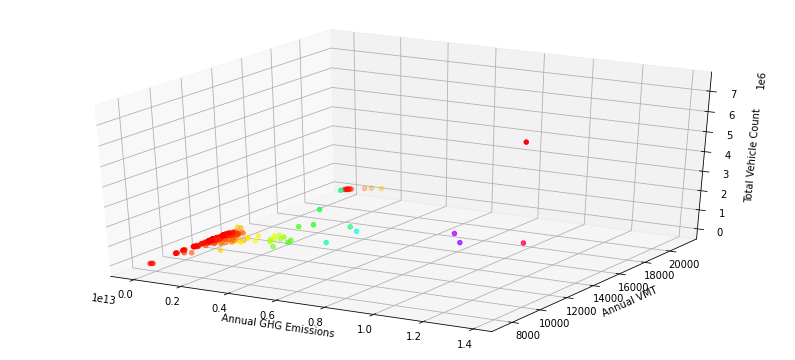

In [91]:
fig1=plt.figure(figsize=(14,14))
ax1 = fig1.add_subplot(211,projection='3d')
zdata = model['total_vehicle_count']
xdata = model['annual_ghg_emissions']
ydata = model['annual_vmt']
ax1.scatter3D(xdata, ydata, zdata, c=xdata, cmap='hsv');
ax1.set_ylabel('Annual VMT')
ax1.set_xlabel('Annual GHG Emissions')
ax1.set_zlabel('Total Vehicle Count')

Text(0.5, 0, 'Total Vehicle Count')

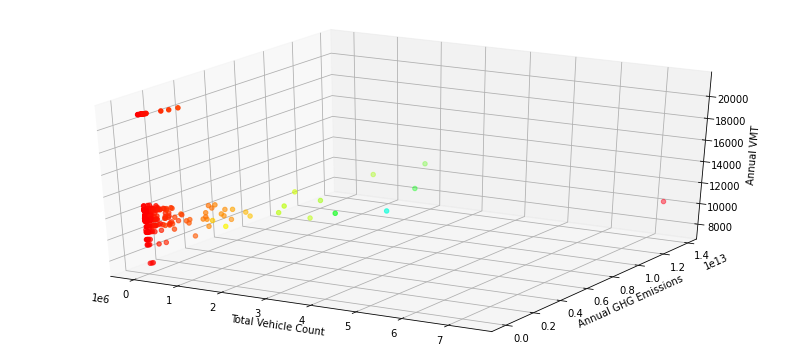

In [92]:
fig2=plt.figure(figsize=(14,14))
ax2 = fig2.add_subplot(211,projection='3d')
xdata = model['total_vehicle_count']
ydata = model['annual_ghg_emissions']
zdata = model['annual_vmt']
ax2.scatter3D(xdata, ydata, zdata, c=xdata, cmap='hsv');
ax2.set_zlabel('Annual VMT')
ax2.set_ylabel('Annual GHG Emissions')
ax2.set_xlabel('Total Vehicle Count')

Text(0.5, 0, 'Total Vehicle Count')

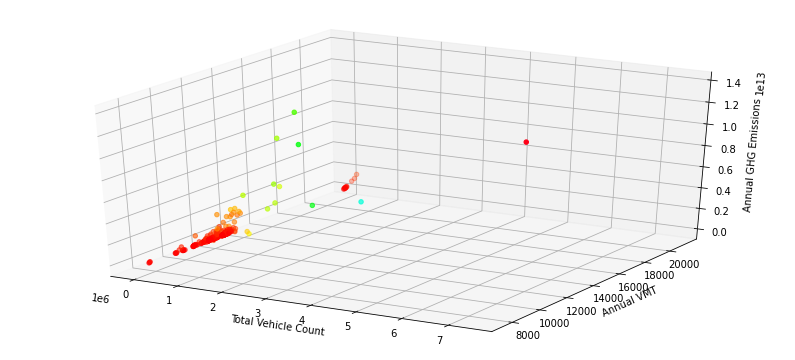

In [93]:
fig3=plt.figure(figsize=(14,14))
ax3 = fig3.add_subplot(211,projection='3d')
xdata = model['total_vehicle_count']
zdata = model['annual_ghg_emissions']
ydata = model['annual_vmt']
ax3.scatter3D(xdata, ydata, zdata, c=xdata, cmap='hsv');
ax3.set_ylabel('Annual VMT')
ax3.set_zlabel('Annual GHG Emissions')
ax3.set_xlabel('Total Vehicle Count')

**[Contour 3D Plot](https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html)**
Attempts to make a 3D contour plot were unsuccessful because this requires that the zdata to actually have 2 dimensions, and to be a function of x and y. In other words, currently, it is just a single axis, unrelated to x and y. In short, z needs to be a grid array. This is possible, but requires additional troubleshooting, probably using the [Interpolate Data function from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html).

#### Limitations with 3D Plotting
3D plots are most useful when your X, Y and Z values are all continuous variables. For this reason, including state in the diagram is not possible / not useful for analysis. It is also difficult to align the view well, so adjustment might be required. Once a view is chosen from the above selection, delivering the rest of the raw graphs for each of the 3 states will be trivial.

#### Future Works - Part 1
The first thing that comes to mind is figuring out a budget to pay for the EC2 uptime -- and finally being a part of a paper that enters the 21st century in augmenting the static written paper with a user-friendly portal to actually explore the data. It will probably cost $20 to have the system up all year, depending on traffic.


number of vehicles (meaning automobiles) in the united states: https://www.statista.com/statistics/196072/number-of-registered-automobiles-in-texas/
find out annual GHG emissions due to vehicles from each state. Find this out using a combination of knowing the number of vehicles in each type in that state and multiplying by fuel GHG factor. then, find the differential between carbon emissions (2017 optimised versus 2017 not-optimised).

#### 01/18/2021 Additional Future Works Ideas
I also suggest the following:
- Expanding the remit of this project beyond CA, TX, MN to the rest of the United States
- Creating a recommender engine that discerns where viable growth is to better understand where to put new stations.
    - (maybe looking at market trend data for consumer purchasing decisions), fuel pump data
- Fuel pump data can also be used to understand the bottom-up figures for carbon emissions.
- Expand to trucking and other forms of transport outside of automotive.

In [95]:
model.head(12)

,County,State,annual_ghg_emissions,annual_operating_cost,total_annual_cost,annual_fuel_use,total_vehicle_count,vehicle_split_BEV,vehicle_split_FFV,vehicle_split_SIDI,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area,census_area,census_totpop,census_urbpop,census_rurpop,pct_rural,pop_density,county_class,ghg_globalrank,popden_globalrank,censusarea_globalrank,ghg_staterank,popden_staterank,censusarea_staterank,median_household_income_2018,household_income_ID,annual_vmt,Efuel Station Count,e85_area,E85 Station Count
0,Alameda,CA,1783929600000.00,318966620.00,7192956300.00,136290200.00,1217269.00,1217269.00,0.00,0.00,100.00,0.00,0.00,100.00,739.02,1510271,1504402,5869,0.40,2043.62,urban,28.00,9.00,293.00,14.00,4.00,49.00,"$101,744",8,10829.72,317.00,52.61,6.00
1,Contra Costa,CA,4027894200000.00,240519220.00,5423903700.00,102770660.00,917891.00,917891.00,0.00,0.00,100.00,0.00,0.00,100.00,715.94,1049025,1040709,8316,0.80,1465.25,urban,13.00,12.00,296.00,8.00,7.00,51.00,"$101,463",8,10829.72,162.00,18.49,1.00
2,San Francisco,CA,1565396800000.00,119103380.00,2685878000.00,50891291.00,454533.00,454533.00,0.00,0.00,100.00,0.00,0.00,100.00,46.87,805235,805235,0,0.00,17179.08,urban,33.00,1.00,399.00,16.00,1.00,58.00,"$110,601",8,10829.72,223.00,97.86,1.00
3,San Mateo,CA,3143350500000.00,187700110.00,4232790000.00,80201763.00,716318.00,716318.00,0.00,0.00,100.00,0.00,0.00,100.00,448.41,718451,704865,13586,1.90,1602.23,urban,17.00,10.00,369.00,9.00,5.00,56.00,"$122,930",8,10829.72,281.00,37.80,2.00
4,Alpine,CA,3585886300.00,1133274.62,12695918.30,420333.98,1821.00,396.96,0.00,1424.04,21.80,0.00,78.20,21.80,738.33,1175,0,1175,100.00,1.59,rural,393.00,380.00,294.00,58.00,58.00,50.00,"$55,384",6,9828.84,2.00,0.00,0.00
5,Amador,CA,71470663000.00,15703854.50,198967876.00,5947661.70,29750.00,12759.69,0.00,16990.31,42.90,0.00,57.10,42.89,594.58,38091,15075,23016,60.40,64.06,rural,235.00,117.00,335.00,46.00,36.00,54.00,"$58,515",6,9828.84,9.00,0.00,0.00
6,Calaveras,CA,98361826000.00,36755748.00,392792573.00,13531418.26,55341.00,6895.82,0.00,48445.18,12.50,0.00,87.50,12.46,1020.01,45578,11208,34370,75.40,44.68,rural,198.00,150.00,126.00,43.00,39.00,40.00,"$62,984",6,9828.84,3.00,0.00,0.00
7,Lassen,CA,25027358900.00,10962502.54,112205048.40,4009361.11,15536.00,498.27,0.00,15037.73,3.20,0.00,96.80,3.21,4541.18,34895,10285,24610,70.50,7.68,rural,335.00,313.00,12.00,55.00,51.00,8.00,"$57,705",6,9828.84,2.00,0.00,0.00
8,Mariposa,CA,43932691000.00,11913482.10,136152784.00,4433092.46,19670.00,5019.83,0.00,14650.17,25.50,0.00,74.50,25.52,1448.82,18251,0,18251,100.00,12.60,rural,284.00,276.00,69.00,50.00,49.00,31.00,"$51,402",6,9828.84,7.00,0.00,0.00
9,Plumas,CA,25952409400.00,10058090.19,106466700.20,3697381.55,14944.00,1565.75,0.00,13378.25,10.50,0.00,89.50,10.48,2553.04,20007,5197,14810,74.00,7.84,rural,331.00,311.00,34.00,54.00,50.00,22.00,"$55,079",6,9828.84,3.00,0.00,0.00


In [96]:
model.to_csv('model_resultsv3.9.csv')

In [97]:
model.shape

(399, 33)

In [98]:
model[model['vehicle_pc_FFV']>model['e85_area']][['County','State','vehicle_pc_FFV','e85_area']]
# model.e85_area.describe()

,County,State,vehicle_pc_FFV,e85_area
11,Butte,CA,6.70,6.66
15,Kern,CA,2.00,1.95
17,Madera,CA,1.40,1.38
23,Riverside,CA,16.80,16.79
24,San Bernardino,CA,4.30,4.25
28,Stanislaus,CA,14.10,14.10
33,Glenn,CA,0.60,0.58
37,Tulare,CA,2.50,2.46
48,Ventura,CA,7.00,6.96
70,Carlton,MN,28.80,28.80


In [99]:
model[model['vehicle_pc_BEV']>model['efuels_area']][['County','State','vehicle_pc_BEV','efuels_area']]

,County,State,vehicle_pc_BEV,efuels_area
4,Alpine,CA,21.80,21.80
5,Amador,CA,42.90,42.89
6,Calaveras,CA,12.50,12.46
9,Plumas,CA,10.50,10.48
11,Butte,CA,69.30,69.30
13,Fresno,CA,67.30,67.29
14,Inyo,CA,43.40,43.36
15,Kern,CA,62.80,62.77
16,Kings,CA,72.20,72.15
17,Madera,CA,70.80,70.76
